In [1]:
import numpy as np
import tensorflow as tf
import os
import time
slim = tf.contrib.slim # native Tensorflow still hasn't batch norm layer, so I use "slim" library
from scipy.io import loadmat 
from scipy.misc import imread
from scipy.misc import imresize
from random import shuffle
from datetime import timedelta
from layers import binary_layer, fc_layer # bunch of wrapped layers that are we use to run the network

In [2]:
dataset_name = 'imdb'
dataset_path = '../datasets/imdb_crop/imdb.mat'
images_path = '../datasets/imdb_crop/'
face_score_treshold = 3
dataset = loadmat(dataset_path)
image_names_array = dataset['imdb']['full_path'][0, 0][0]
gender_classes = dataset['imdb']['gender'][0, 0][0]
face_score = dataset['imdb']['face_score'][0, 0][0]
second_face_score = dataset['imdb']['second_face_score'][0, 0][0]
face_score_mask = face_score > face_score_treshold
second_face_score_mask = np.isnan(second_face_score)
unknown_gender_mask = np.logical_not(np.isnan(gender_classes))
mask = np.logical_and(face_score_mask, second_face_score_mask)
mask = np.logical_and(mask, unknown_gender_mask)
image_names_array = image_names_array[mask]
gender_classes = gender_classes[mask].tolist()
image_names = []

for image_name_arg in range(image_names_array.shape[0]):
    image_name = image_names_array[image_name_arg][0]
    image_names.append(image_name)
    
ground_truth_data = dict(zip(image_names, gender_classes))

In [3]:
def split_data(ground_truth_data, training_ratio=.8, do_shuffle=False):
    ground_truth_keys = sorted(ground_truth_data.keys())
    if do_shuffle == True:
        shuffle(ground_truth_keys)
    num_train = int(round(training_ratio * len(ground_truth_keys)))
    train_keys = ground_truth_keys[:num_train]
    validation_keys = ground_truth_keys[num_train:]
    return train_keys, validation_keys

In [4]:
def to_categorical(integer_classes, num_classes=3):
    integer_classes = np.asarray(integer_classes, dtype='int')
    num_samples = integer_classes.shape[0]
    categorical = np.zeros((num_samples, num_classes))
    categorical[np.arange(num_samples), integer_classes] = 1
    return categorical

In [5]:
def generate_val_batch(j):
    
    test_batch_size = 256
    x_batch = []
    y_true_batch = [] 
    i = j
    while len(y_true_batch) < test_batch_size and i < len(val_keys):
        idx = i
        image_path = images_path + val_keys[idx]
        image_array = imread(image_path)
        image_array = imresize(image_array, [img_size, img_size])
        num_image_channels = len(image_array.shape)
        if num_image_channels != 3:
            i += 1
            continue
            
        image_array = image_array.astype('float32')
        x_batch.append(image_array)
        
        ground_truth = ground_truth_data[val_keys[idx]]
        y_true_batch.append(ground_truth)
        i += 1

    
    y_true_batch = to_categorical(y_true_batch, num_classes=2)
    y_true_batch = np.asarray(y_true_batch, dtype='float32')
    x_batch = np.asarray(x_batch, dtype='float32')

    return x_batch, y_true_batch, i 

In [6]:
train_keys, val_keys = split_data(ground_truth_data)

In [7]:
signatures_path = './floating_signatures/'

In [8]:
def generate_batch():
    x_batch = []
    y_true_batch = []
    i = 0
    while i < 64:
        idx = np.random.choice(len(train_keys), replace=False)
        sign_path = signatures_path +  train_keys[idx][:-4] + '.npy'
        if not os.path.exists(sign_path):
            continue
        signature = np.load(sign_path)
        ground_truth = ground_truth_data[train_keys[idx]]
    
        x_batch.append(signature)
        y_true_batch.append(ground_truth)
        i += 1
        
    y_true_batch = to_categorical(y_true_batch, num_classes=2)
    y_true_batch = np.asarray(y_true_batch, dtype='float32')
    x_batch = np.asarray(x_batch, dtype='float32')
    
    return x_batch, y_true_batch

In [9]:
num_classes = 2

In [10]:
x = tf.placeholder(tf.float32, shape=[None, 256], name="x")
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1, name='y_true_cls')

hidd_layer = binary_layer(x, 256, 256, name="binary")
fc2 = fc_layer(hidd_layer, 256, num_classes, use_relu=False)
y_pred = tf.nn.softmax(fc2, name="y_pred")
y_pred_cls = tf.argmax(y_pred, dimension=1, name="y_pred_cls")
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [11]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

In [12]:
def optimize(num_iterations):
    start_time = time.time()
    
    for i in range(num_iterations):
        x_batch, y_true_batch = generate_batch()
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict_train)
        if i + 1 % 100 == 0:
            acc = session.run(accuracy, feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i, acc))
                    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [14]:
optimize(2500)

Optimization Iteration:      0, Training Accuracy:  89.1%
Optimization Iteration:    100, Training Accuracy:  85.9%
Optimization Iteration:    200, Training Accuracy:  87.5%
Optimization Iteration:    300, Training Accuracy:  90.6%
Optimization Iteration:    400, Training Accuracy:  90.6%
Optimization Iteration:    500, Training Accuracy:  87.5%
Optimization Iteration:    600, Training Accuracy:  85.9%
Optimization Iteration:    700, Training Accuracy:  90.6%
Optimization Iteration:    800, Training Accuracy:  90.6%
Optimization Iteration:    900, Training Accuracy:  92.2%
Optimization Iteration:   1000, Training Accuracy:  89.1%
Optimization Iteration:   1100, Training Accuracy:  84.4%
Optimization Iteration:   1200, Training Accuracy:  95.3%
Optimization Iteration:   1300, Training Accuracy:  90.6%
Optimization Iteration:   1400, Training Accuracy:  89.1%
Optimization Iteration:   1500, Training Accuracy:  93.8%
Optimization Iteration:   1600, Training Accuracy:  85.9%
Optimization I

In [35]:
def get_binary_and_euqlid_signatures():

    for subdir, dirs, files in os.walk(signatures_path):
        for file in files:
            file_path = subdir + os.sep + file
            if file_path.endswith(".npy"):
                signature = np.load(file_path)
                if signature.shape != (256,):
                    continue
                tanh_signature = session.run(hidd_layer, feed_dict={x: [signature]})
                tanh_signature = np.squeeze(tanh_signature)
                signature = np.ceil(tanh_signature) # added from convert_to_booleans
                signature = signature.astype('int32') # added from convert_to_booleans
                signature = signature.astype('bool') # added from convert_to_booleans
                save_dir = './binary_signatures/' + str(subdir[-2:]) + os.sep
                save_dir_float = './euqlidean_signatures/' + str(subdir[-2:]) + os.sep
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                    
                if not os.path.exists(save_dir_float):
                    os.makedirs(save_dir_float)
                    
                save_path = save_dir + str(file[:-4])
                save_path_float = save_dir_float + str(file[:-4])
                np.save(save_path_float, tanh_signature)
                np.save(save_path, signature)            

In [36]:
get_binary_and_euqlid_signatures()

In [24]:
import from_image_to_floats
import operator
def compute_k_nearest_neighbors(image_path, k=10):
    floats = from_image_to_floats.process_image(image_path)
    _, binary_signature = from_image_to_floats.get_e_and_b_signature(floats)
    
    dists = {}
    for subdir, dirs, files in os.walk('./binary_signatures/'):
        for file in files:
            file_path = subdir + os.sep + file
            if file_path.endswith(".npy"):
                sign = np.load(file_path)
                if sign.shape != (256,):
                    continue
                dist = np.count_nonzero(binary_signature!=sign)
                key = file_path[20:-4]
                dists[key] = dist 
            
    nearest_k = sorted(dists.items(), key=operator.itemgetter(1))[:k]
    return nearest_k  

In [25]:
dists_list = compute_k_nearest_neighbors('me2.jpg', k=10)

In [21]:
def plot_nearest_images(img_list):
    #target_img =  PIL.Image.open(target_img_path)
    #plot_image_big(target_img)
    print("Target image")
    for i in range(len(img_list)):
        img_path = '../datasets/imdb_crop/' + img_list[i][0] + '.jpg'
        image = PIL.Image.open(img_path)
        plot_image_big(image)
        print("distance to this image is " + str(img_list[i][1]))

In [15]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [14]:
from IPython.display import Image, display
import PIL.Image
#aaa_img_path = '../datasets/imdb_crop/00/nm0000100_rm96704768_1955-1-6_2003.jpg'
#bbb_img_path = '../datasets/imdb_crop/00/nm0000100_rm46373120_1955-1-6_2003.jpg'
#aaa_img = PIL.Image.open(aaa_img_path)
#bbb_img = PIL.Image.open(bbb_img_path)

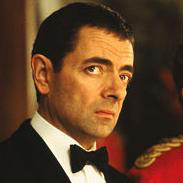

In [244]:
plot_image_big(aaa_img)


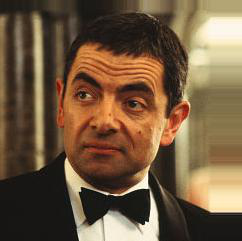

In [245]:
plot_image_big(bbb_img)

In [246]:
res1 = np.count_nonzero(aaa!=bbb)
res1

46

In [154]:
from scipy.spatial.distance import hamming

In [155]:
res2 = hamming(aaa, bbb)
res2*256

3.0